==========================================================================

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# ----------------------------------------------
# Paso 1: Cargar los Datos
# ----------------------------------------------

In [2]:
# Definir las rutas a los directorios donde están los archivos CSV
directory = 'C:/Users/julia/Desktop/Forecasting-Formula1-Podiums-With-TSLM-NeuralNetwork/Bahrain-GP-RaceLapTimes-VERSTAPPEN.csv'

# Función para cargar los datos de una temporada
def load_data(directory):
    data = {}
    if os.path.exists(directory):
        df = pd.read_csv(directory)
        #print(df)
        # Verificar que todas las columnas esperadas estén presentes
        expected_columns = ['Year','Driver', 'LapTime', 'LapNumber']
        if all(col in df.columns for col in expected_columns):
            data = df
        else:
            print("Advertencia: El archivo no tiene todas las columnas esperadas.")
        print("Carga exitosa")
    else:
        print(f"Archivo no encontrado: {directory}")
    return data

# Cargar datos de 2024 y 2025
data = load_data(directory)

print(data.head())

Carga exitosa
   Year Driver        LapTime  LapNumber
0  2018    VER   00:01:29.374        1.1
1  2019    VER   00:01:29.579        1.1
2  2019    VER   00:01:29.143        2.1
3  2019    VER   00:01:29.109        3.1
4  2019    VER   00:01:28.752        4.1



# ----------------------------------------------
# Paso 2: Procesar los Datos
# ----------------------------------------------


In [3]:
def convert_time_to_seconds(time_str):
    """Convierte un string de tiempo en formato 'HH:MM:SS.sss' a segundos."""
    try:
        h, m, s = time_str.split(':')
        return int(h) * 3600 + int(m) * 60 + float(s)
    except:
        return np.nan  # Para evitar errores si hay valores inválidos
        
data ['LapTime'] = data['LapTime'].apply(convert_time_to_seconds)


In [4]:
# Visualizar rendimiento 2024
df_perf_2024 = pd.DataFrame(data)  # Transponer para que las carreras estén como filas
df_perf_2024.head()

,Year,Driver,LapTime,LapNumber
0,2018,VER,89.374,1.1
1,2019,VER,89.579,1.1
2,2019,VER,89.143,2.1
3,2019,VER,89.109,3.1
4,2019,VER,88.752,4.1



# ----------------------------------------------
# Paso 3: Dividir en Entrenamiento, Validación y Prueba
# ----------------------------------------------


In [5]:
# Función para crear secuencias a partir del vector de tiempos
def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Supongamos que ya tenés la columna 'LapTime' en segundos
lap_times = data['LapTime'].values.astype(np.float32)

# Normalización
scaler = MinMaxScaler()
lap_times_scaled = scaler.fit_transform(lap_times.reshape(-1, 1)).flatten()

# Crear secuencias
window_size = 10
X, y = create_sequences(lap_times_scaled, window_size=window_size)

# Ajustar dimensiones para LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Secuencias creadas: {X.shape}")
print(f"   - Tamaño de train: {X_train.shape}, test: {X_test.shape}")

✅ Secuencias creadas: (298, 10, 1)
   - Tamaño de train: (238, 10, 1), test: (60, 10, 1)



# ----------------------------------------------
# Paso 4: Diseñar y Entrenar el Modelo LSTM
# ----------------------------------------------


In [6]:
def build_lstm_model(input_shape, lstm_units=32, dense_units=16, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = LSTM(lstm_units)(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Entrenar modelo
model = build_lstm_model(input_shape=X.shape[1:])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=16,              # más epochs con early stopping
    batch_size=8,           # más pequeño para mayor estabilidad
    #callbacks=[early_stop]
)


Epoch 1/16
24/24 [==============================] - 3s 34ms/step - loss: 0.1275 - mae: 0.2939 - val_loss: 0.0400 - val_mae: 0.1472
Epoch 2/16
24/24 [==============================] - 0s 9ms/step - loss: 0.0318 - mae: 0.1329 - val_loss: 0.0410 - val_mae: 0.1640
Epoch 3/16
24/24 [==============================] - 0s 10ms/step - loss: 0.0280 - mae: 0.1172 - val_loss: 0.0364 - val_mae: 0.1456
Epoch 4/16
24/24 [==============================] - 0s 10ms/step - loss: 0.0248 - mae: 0.1121 - val_loss: 0.0357 - val_mae: 0.1441
Epoch 5/16
24/24 [==============================] - 0s 7ms/step - loss: 0.0239 - mae: 0.1077 - val_loss: 0.0372 - val_mae: 0.1521
Epoch 6/16
24/24 [==============================] - 0s 9ms/step - loss: 0.0240 - mae: 0.1082 - val_loss: 0.0341 - val_mae: 0.1382
Epoch 7/16
24/24 [==============================] - 0s 8ms/step - loss: 0.0229 - mae: 0.1025 - val_loss: 0.0344 - val_mae: 0.1418
Epoch 8/16
24/24 [==============================] - 0s 8ms/step - loss: 0.0205 - mae: 0

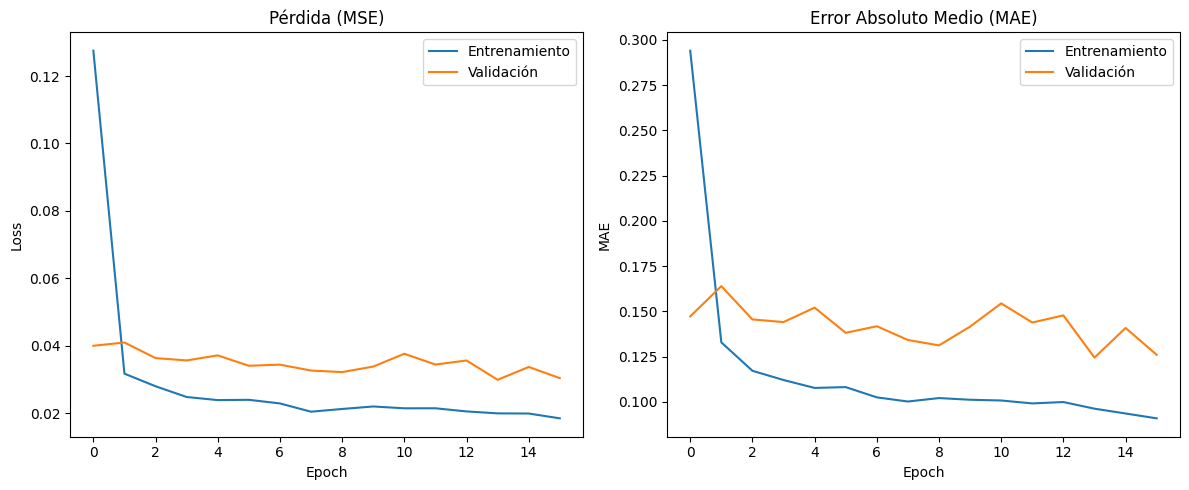

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


# ----------------------------------------------
# Paso 5: Predicción y Evaluación en Prueba
# ----------------------------------------------


In [13]:
def seconds_to_time_str(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hours:02}:{minutes:02}:{secs:06.3f}"

# Usamos las últimas 10 vueltas como input
last_150_laps = lap_times[-150:]
last_150_scaled = scaler.transform(last_150_laps.reshape(-1, 1)).reshape(1, 150, 1)

# Predicción del modelo
predicted_scaled = model.predict(last_150_scaled)
predicted_seconds = scaler.inverse_transform(predicted_scaled)[0][0]

# Convertir a formato hh:mm:ss.sss
formatted_time = seconds_to_time_str(predicted_seconds)

# Mostrar resultado
print(f"⏱️ Tiempo de vuelta estimado para Bahréin 2025: {formatted_time} (≈ {predicted_seconds:.3f} segundos)")


1/1 [==============================] - 0s 28ms/step
⏱️ Tiempo de vuelta estimado para Bahréin 2025: 00:01:34.437 (≈ 94.437 segundos)


1/1 [==============================] - 0s 25ms/step


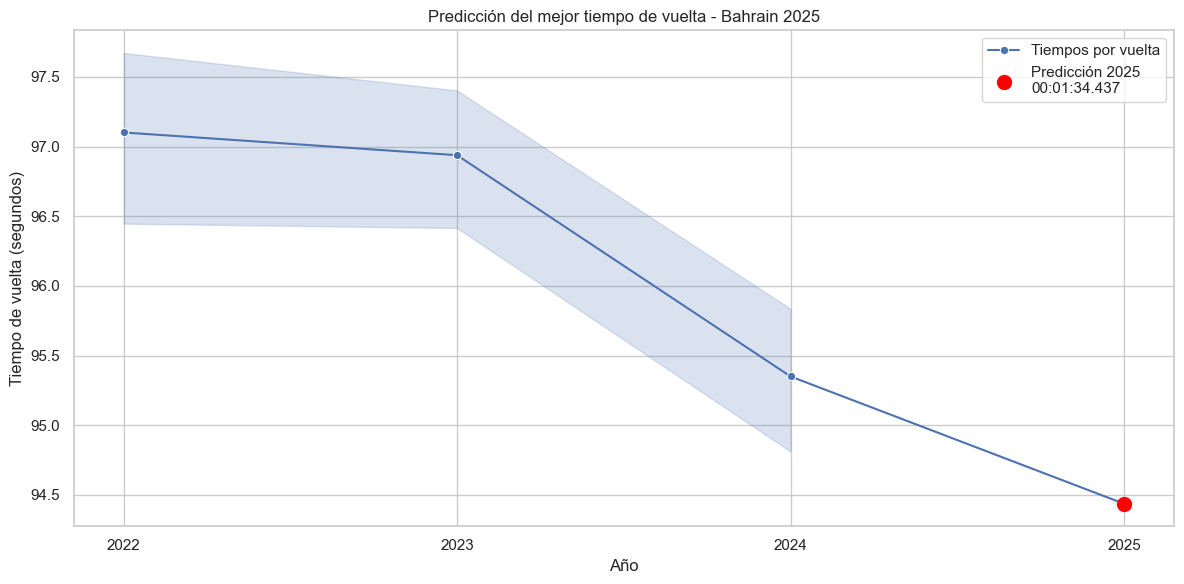

⏱️ Tiempo de vuelta estimado para Bahréin 2025: 00:01:34.437 (94.437 segundos)


In [22]:
# Función: segundos a formato hh:mm:ss.sss
def seconds_to_time_str(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hours:02}:{minutes:02}:{secs:06.3f}"

import seaborn as sns

# Asegurarse de que Seaborn tenga estilo bonito
sns.set(style="whitegrid")

# Últimas 10 vueltas
last_150_rows = data.tail(150).copy()
last_150_rows['Year'] = last_150_rows['Year'].astype(str)

# Predicción
last_150_laps = last_150_rows['LapTime'].values
last_150_scaled = scaler.transform(last_150_laps.reshape(-1, 1)).reshape(1, 150, 1)
predicted_scaled = model.predict(last_150_scaled)
predicted_time_seconds = scaler.inverse_transform(predicted_scaled)[0][0]
formatted_time = seconds_to_time_str(predicted_time_seconds)

# Crear DataFrame extendido para graficar con predicción
extended_df = last_150_rows.copy()
extended_df.loc[len(extended_df)] = {
    'Year': '2025',
    'LapTime': predicted_time_seconds,
    'Driver': 'Verstappen',
    'LapNumber': np.nan  # o lo que prefieras
}

# Plot con Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=extended_df, x='Year', y='LapTime', marker='o', label='Tiempos por vuelta')

# Agregar marcador especial para predicción
plt.scatter('2025', predicted_time_seconds, color='red', s=100, label=f'Predicción 2025\n{formatted_time}', zorder=5)

# Etiquetas
plt.title("Predicción del mejor tiempo de vuelta - Bahrain 2025")
plt.xlabel("Año")
plt.ylabel("Tiempo de vuelta (segundos)")
plt.legend()
plt.tight_layout()
plt.show()

# Resultado por consola
print(f"⏱️ Tiempo de vuelta estimado para Bahrain 2025: {formatted_time} ({predicted_time_seconds:.3f} segundos)")


In [11]:
# Guardar el modelo completo
model.save('modelo_lstm_formula1.h5')
